In [1]:
from tqdm import tqdm
import treescope as ts
import matplotlib.pyplot as plt
import torch


class Logger(dict):
    def log(self, vals={}, *, pbar=None, prefix="", suffix="", **kwargs):
        vals = {**vals, **kwargs}
        for k, v in vals.items():
            self.setdefault(k, []).append(v)
        if pbar is not None:
            smooth_vals = {
                f"{prefix}{k}{suffix}": f"{sum(self[k][-10:])/10:.6f}"
                for k in vals.keys()
            }
            pbar.set_postfix(**smooth_vals)

In [2]:
from data import DNADataset, DNADiffusionDataset
from vae import *

dataset = DNADataset("hf://datasets/Zehui127127/latent-dna-diffusion/sequence.csv")
autoencoder = torch.load(f"model_cycle_4.pth", map_location="cpu")
ts.display(autoencoder)
diffusion_dataset = DNADiffusionDataset(dataset, autoencoder, batch_size=1024, device="cuda:1")

Loading data from hf://datasets/Zehui127127/latent-dna-diffusion/sequence.csv...
Processing data...
Done!


/tmp/ipykernel_1009403/3939411995.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder = torch.load(f"model_cycle_4.pth", map_location="cpu")


Pre encoding data: 100%|██████████| 156/156 [00:21<00:00,  7.14it/s]


In [3]:
import torch
from torch import nn
from torch.nn import functional as F


class ZeroInitLinear(nn.Linear):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        nn.init.zeros_(self.weight)
        nn.init.zeros_(self.bias)


class FeedForward(nn.Sequential):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__(
            nn.Linear(in_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, out_dim),
        )


class Attention(nn.Module):
    def __init__(self, dim: int, num_heads: int = 8) -> None:
        super().__init__()
        assert dim % num_heads == 0, "dim should be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Linear(dim, dim, bias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        q, k, v = qkv.permute(2, 0, 3, 1, 4).unbind(0)
        x = F.scaled_dot_product_attention(q, k, v)
        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x


class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, expand=4):
        super().__init__()
        self.modulation = nn.Sequential(nn.SiLU(), ZeroInitLinear(dim, 6 * dim))
        self.norm1 = nn.LayerNorm(dim, elementwise_affine=False)
        self.attn = Attention(dim, num_heads)
        self.norm2 = nn.LayerNorm(dim, elementwise_affine=False)
        self.ff = FeedForward(dim, dim * expand, dim)

    def forward(self, x, c):
        c = torch.chunk(self.modulation(c), 6, dim=-1)
        shift1, scale1, gate1, shift2, scale2, gate2 = c
        x = x + gate1 * self.attn(shift1 + scale1 * self.norm1(x))
        x = x + gate2 * self.ff(shift2 + scale2 * self.norm2(x))
        return x


class PosEmbedding(nn.Module):
    def __init__(self, emb_dim, max_len=32):
        super().__init__()
        self.embed = nn.Embedding(max_len, emb_dim)
        self.ff = FeedForward(emb_dim, emb_dim, emb_dim)

    def forward(self, x):
        pos = torch.arange(x.size(-2), device=x.device)
        return self.embed(pos)


class TimeEmbedding(nn.Module):
    def __init__(self, emb_dim, resolution=32):
        super().__init__()
        self.embed = nn.Embedding(resolution, emb_dim)
        self.ff = FeedForward(emb_dim, emb_dim, emb_dim)

    def forward(self, t):
        pos = t * (self.embed.num_embeddings - 1)
        pos_high = torch.ceil(pos).long()
        pos_low = torch.floor(pos).long()
        emb_low = self.embed(pos_low) * (pos_high - pos).unsqueeze(-1)
        emb_high = self.embed(pos_high) * (pos - pos_low).unsqueeze(-1)
        return emb_low + emb_high


class TransformerCNF(nn.Module):
    def __init__(self, in_dim, dim, num_heads=8, depth=16):
        super().__init__()
        self.token_emb = FeedForward(in_dim, dim, dim)
        self.pos_emb = PosEmbedding(dim)
        self.time_emb = TimeEmbedding(dim)

        self.blocks = nn.ModuleList(
            TransformerBlock(dim, num_heads) for _ in range(depth)
        )
        self.token_deemb = FeedForward(dim, dim, in_dim)

    def forward(self, x, t):
        c = self.time_emb(t.unsqueeze(-1))
        x = self.token_emb(x) + self.pos_emb(x)
        for block in self.blocks:
            x = block(x, c)
        x = self.token_deemb(x)
        return x

    def loss(self, t, x0, x1):
        xt = x1 * t[..., None, None] + x0 * (1 - t[..., None, None])
        dx = x1 - x0
        return F.mse_loss(self(xt, t), dx)

    def push(self, x, steps=16):
        t = torch.arange(0, 1, 1 / steps, device=x.device)
        for t in torch.arange(0, 1, 1 / steps, device=x.device):
            x = x + (1 / steps) * self(x, t)
        return x


model = TransformerCNF(in_dim=32, dim=256, num_heads=8, depth=16)
ts.display(model, autovisualize=True)

In [ ]:
device = torch.device("cuda:2")
model = model.to(device=device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
dataloader = torch.utils.data.DataLoader(
    diffusion_dataset, batch_size=1024, shuffle=True, num_workers=1
)

logger = Logger()
epochs = 100
for j in range(epochs):
    for i, batch in enumerate(pbar := tqdm(dataloader)):
        batch = (el.to(device=device, dtype=torch.float32) for el in batch)
        loss = model.loss(*batch)
        logger.log(loss=loss.item(), pbar=pbar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if j+1 % 10 == 0:
        torch.save(model, f"model_epoch_{j+1}.pth")

100%|██████████| 156/156 [00:42<00:00,  3.71it/s, loss=1.516823]


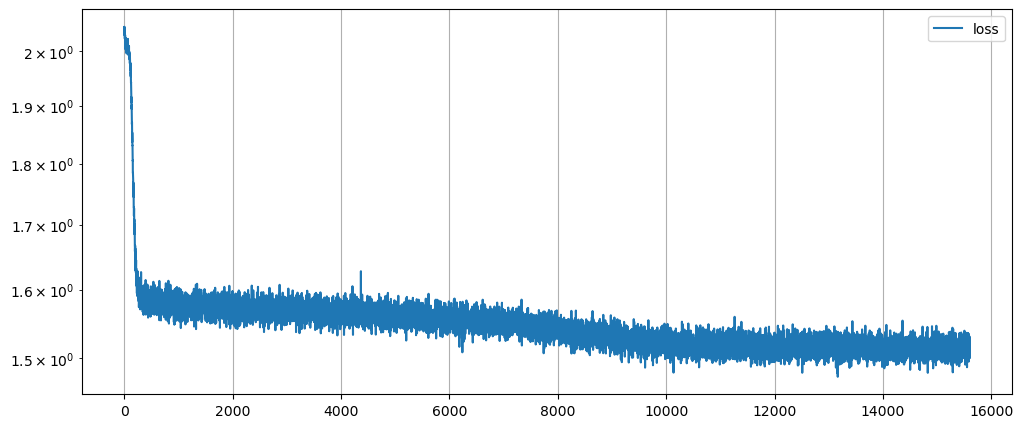

In [6]:
plt.figure(figsize=(12, 5))
plt.semilogy(logger["loss"], label="loss")
plt.legend()
plt.grid()
plt.show()